### Review

- 这是一个使用opencv各种api接口的串烧项目，目的是稍稍加深对api接口的印象（实则肯定会忘，用到的时候再查doc吧）
- 选来选去决定使用哆唻a梦作为src image

- 先后完成了以下功能：

    1. 画出doraemon的最外部轮廓，并用bounding box框住doraemon所属的最小矩形区域

    2. 根据bounding box裁剪图片，并为图片添加opencv水印

    3. 分别使用template matching，feature detection，object detection by color三种方法寻找doraemon的铃铛在图片中的位置并框选（可能由于铃铛的特征太少，前两者都无法应对template旋转的情况，而由于图片中仅有铃铛是黄色，所以color反而做的很好

    4. 通过aruco标定图片位置，将原有图片中aurco标定部分转变成doraemon图片

- 感觉这些功能很像ps（bushi）

In [ ]:
import sys
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

src= cv.imread(r'D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\src.jpg', cv.IMREAD_UNCHANGED)
cv.imshow('original-photo', src)
img=cv.cvtColor(src, cv.COLOR_BGR2GRAY)

blur = cv.blur(img,(5,5))
ret,thred = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

contours, hierarchy = cv.findContours(thred, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt=contours[1]
x,y,w,h = cv.boundingRect(cnt)
cv.rectangle(thred,(x,y),(x+w,y+h),(0,255,0),2)
thred_color = cv.cvtColor(thred, cv.COLOR_GRAY2BGR)
cv.drawContours(thred_color, contours, 1, (20,255,20), 3)
cv.imshow('bounding and something else', thred_color)

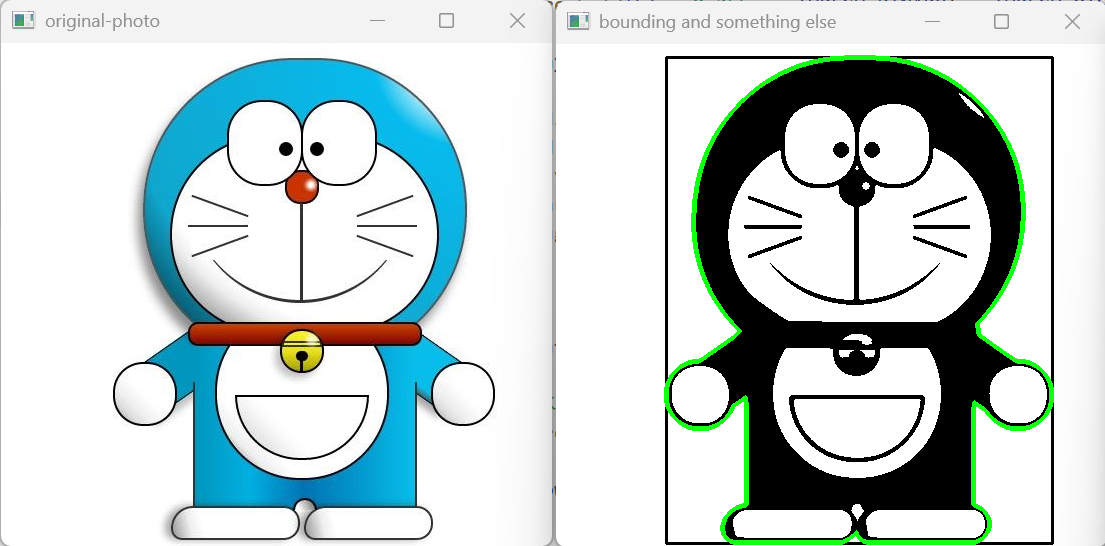

In [2]:
#裁剪img
cutting=src[y:y+h, x:x+w]
cv.imshow('photo after cutting', cutting)

##为img加上opencv水印begin
watermark = cv.imread(r'D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\opencv.png', cv.IMREAD_COLOR_BGR)
rows,cols,channels = watermark.shape
roi = cutting[0:rows, 0:cols]

#获得水印的mask
watermark_gray = cv.cvtColor(watermark,cv.COLOR_BGR2GRAY)
ret, mask = cv.threshold(watermark_gray, 200, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
 
#用mask拿到roi除掉前景的背景
roi_bg = cv.bitwise_and(roi,roi,mask = mask)

#用mask拿到水印的前景
watermark_fg = cv.bitwise_and(watermark,watermark,mask = mask_inv)
 
#合并
dst = cv.add(roi_bg, watermark_fg)
cutting[0:rows, 0:cols ] = dst
cv.imshow('doraemon-with-watermark', cutting)

##end
img=cutting
###然后想找到doraemon的铃铛在图片中的哪个位置（虽然是多此一举）begin
###opencv提供了多种适用于不同情况的object detection方法，以下分别尝试
##法一：使用模板匹配
template = cv.imread(r'D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\bell.jpg', cv.IMREAD_COLOR_BGR)
w, h, _ = template.shape
res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
max_loc = cv.minMaxLoc(res)[3]
  
img_copy = img.copy()
cv.rectangle(img_copy, max_loc, (max_loc[0] + w, max_loc[1] + h), (0, 255, 0), 2)
cv.imshow('bell-detected', img_copy)
#表现很好，但如果bell反转
template = cv.imread(r'D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\bell_reversed.jpg', cv.IMREAD_COLOR_BGR)
w, h, _ = template.shape
res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
max_loc = cv.minMaxLoc(res)[3]

img_copy = img.copy()
cv.rectangle(img_copy, max_loc, (max_loc[0] + w, max_loc[1] + h), (0, 255, 0), 2)
cv.imshow('bell-detected-reversed', img_copy)
#失败了，乱框了一个位置


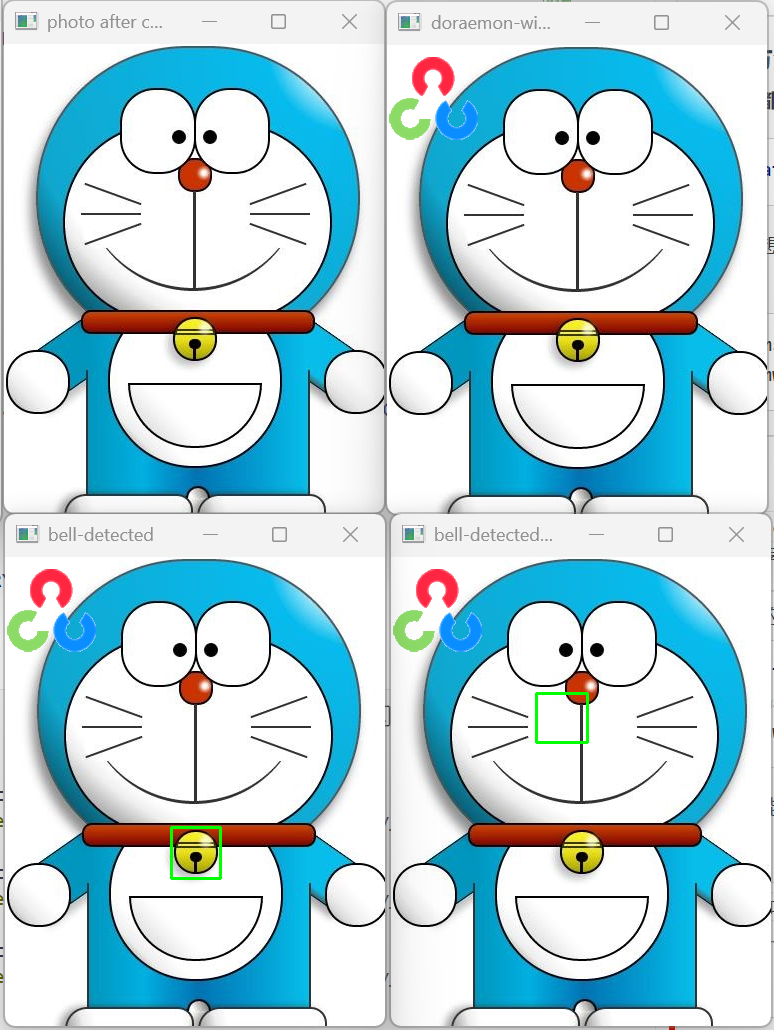

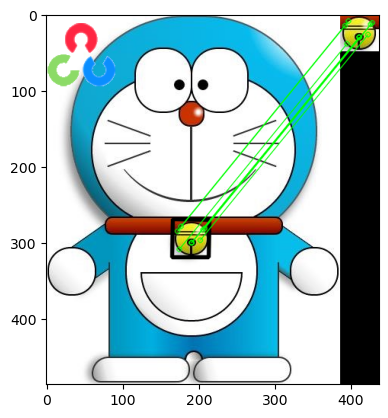

(<matplotlib.image.AxesImage at 0x2056a153550>, None)

In [3]:
##法二：使用STFT特征匹配begin
template = cv.imread(r'D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\bell.jpg', cv.IMREAD_COLOR_BGR)
MIN_MATCH_COUNT = 5

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img, None)
kp2, des2 = sift.detectAndCompute(template, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)  
    #找到映射矩阵
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = None

    w, h, _ = template.shape
    #把模板的四个角点映射到原图上
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)

    img2=img.copy()
    img2 = cv.polylines(img2,[np.int32(dst)],True,0,3, cv.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)

img3 = cv.drawMatches(img2,kp1,template,kp2,good,None,**draw_params)
img3=cv.cvtColor(img3, cv.COLOR_BGR2RGB)
plt.imshow(img3, 'gray'),plt.show()
##事实上，SIFT效果也不行，只能在没有旋转时成功匹配，可能是template特征太少end


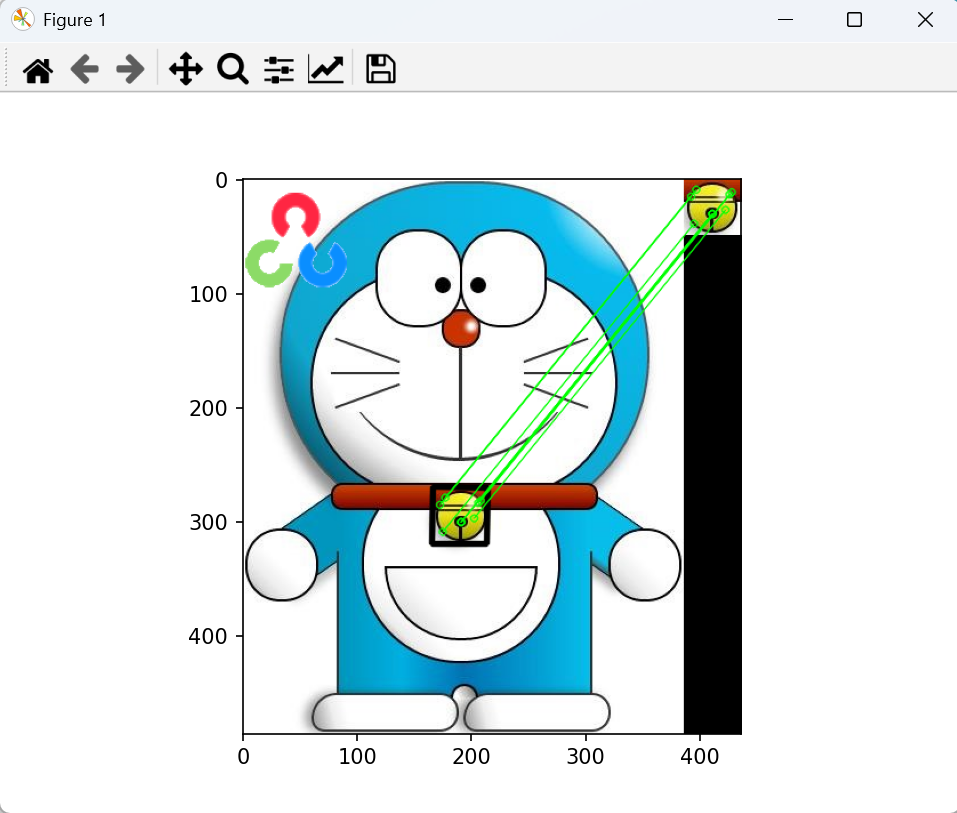

In [4]:
##法三：更大胆一些，使用颜色来做object detection begin
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])
mask = cv.inRange(hsv, lower_yellow, upper_yellow)

#为了把铃铛中的黑线去掉，多次dilation再erosion
mask = cv.morphologyEx(mask, cv.MORPH_DILATE, np.ones((5, 5), np.uint8))
mask = cv.morphologyEx(mask, cv.MORPH_DILATE, np.ones((5, 5), np.uint8))
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, np.ones((5, 5), np.uint8))
mask = cv.morphologyEx(mask, cv.MORPH_ERODE, np.ones((5, 5), np.uint8))
mask = cv.morphologyEx(mask, cv.MORPH_ERODE, np.ones((5, 5), np.uint8))
cv.imshow('mask', mask)
contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt=contours[0]
x,y,w,h = cv.boundingRect(cnt)
img4= img.copy()
cv.rectangle(img4,(x,y),(x+w,y+h),(0,255,0),2)
cv.imshow('bell-detected-by-color', img4)
##效果很好，因为只有铃铛是黄色的，而且能很好应对旋转end

###end


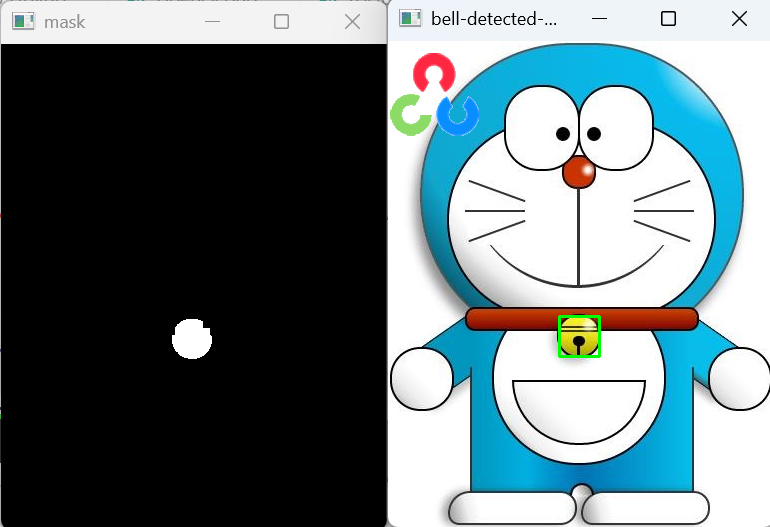

In [5]:
###找完铃铛之后，新的任务情景是：
###（doraemon干了坏事，为了防止被大熊妈妈骂，所以他要变成墙上的一幅画）
###翻译：有一张图片，图片中原本墙上挂了一幅画，现在要用doraemon的图片替换墙上的画（类似于虚拟现实技术）
###当然，墙上的画是有Aruco标记的，所以可以用Aruco标记来定位墙上的画

image_path = r"D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\test.jpg"
im_src = img.copy()

frame = cv.imread(image_path)
outputFile = image_path[:-4]+'_ar_out_py.jpg'

#定位aruco标记
dictionary = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_6X6_250)
parameters = cv.aruco.DetectorParameters()
markerCorners, markerIds, rejectedCandidates = cv.aruco.detectMarkers(frame, dictionary, parameters=parameters)

# 检查是否检测到所有需要的ID
required_ids = [25, 33, 30, 23]
for marker_id in required_ids:
    if markerIds is None or marker_id not in markerIds:
        print(f"未检测到ID为{marker_id}的Aruco标记")
        sys.exit(1)

def get_corner_by_id(markerIds, markerCorners, id, corner_idx):
    index = np.where(markerIds == id)[0][0]
    return np.squeeze(markerCorners[index])[corner_idx]

refPt1 = get_corner_by_id(markerIds, markerCorners, 25, 1)  # 左上
refPt2 = get_corner_by_id(markerIds, markerCorners, 33, 2)  # 右上
refPt3 = get_corner_by_id(markerIds, markerCorners, 30, 0)  # 右下
refPt4 = get_corner_by_id(markerIds, markerCorners, 23, 0)  # 左下

pts_dst = np.array([refPt1, refPt2, refPt3, refPt4], dtype=np.float32)
pts_src = np.array([[0,0], [im_src.shape[1],0], [im_src.shape[1],im_src.shape[0]], [0,im_src.shape[0]]], dtype=np.float32)

# 计算单应性矩阵
h, status = cv.findHomography(pts_src, pts_dst)

warped_image = cv.warpPerspective(im_src, h, (frame.shape[1],frame.shape[0]))

# 获得一个画的部分是白色，其他部分黑的mask
mask = np.zeros([frame.shape[0], frame.shape[1]], dtype=np.uint8)
cv.fillConvexPoly(mask, np.int32([pts_dst]), (255, 255, 255), cv.LINE_AA)
element = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
mask = cv.erode(mask, element, iterations=3)
# 将mask转换为3通道
mask3 = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)/ 255.0

#做一下类型转换要不然老报错
frame32 = frame.astype(np.float32)
warped_image = warped_image.astype(np.float32)
mask3 = mask3.astype(np.float32)

warped_image_masked = cv.multiply(warped_image, mask3)
frame_masked = cv.multiply(frame32, 1 - mask3)
im_out = cv.add(warped_image_masked, frame_masked)

#合并图片
concatenatedOutput = cv.hconcat([frame.astype(np.uint8), im_out.astype(np.uint8)])
cv.imshow("AR using Aruco markers", concatenatedOutput)

cv.imwrite(outputFile, concatenatedOutput.astype(np.uint8))
print("Output file is stored as ", outputFile)


cv.waitKey(0)
cv.destroyAllWindows()

Output file is stored as  D:\vscodefiles\lee_hy_ml_2021_hw\opencv\practice\test_ar_out_py.jpg


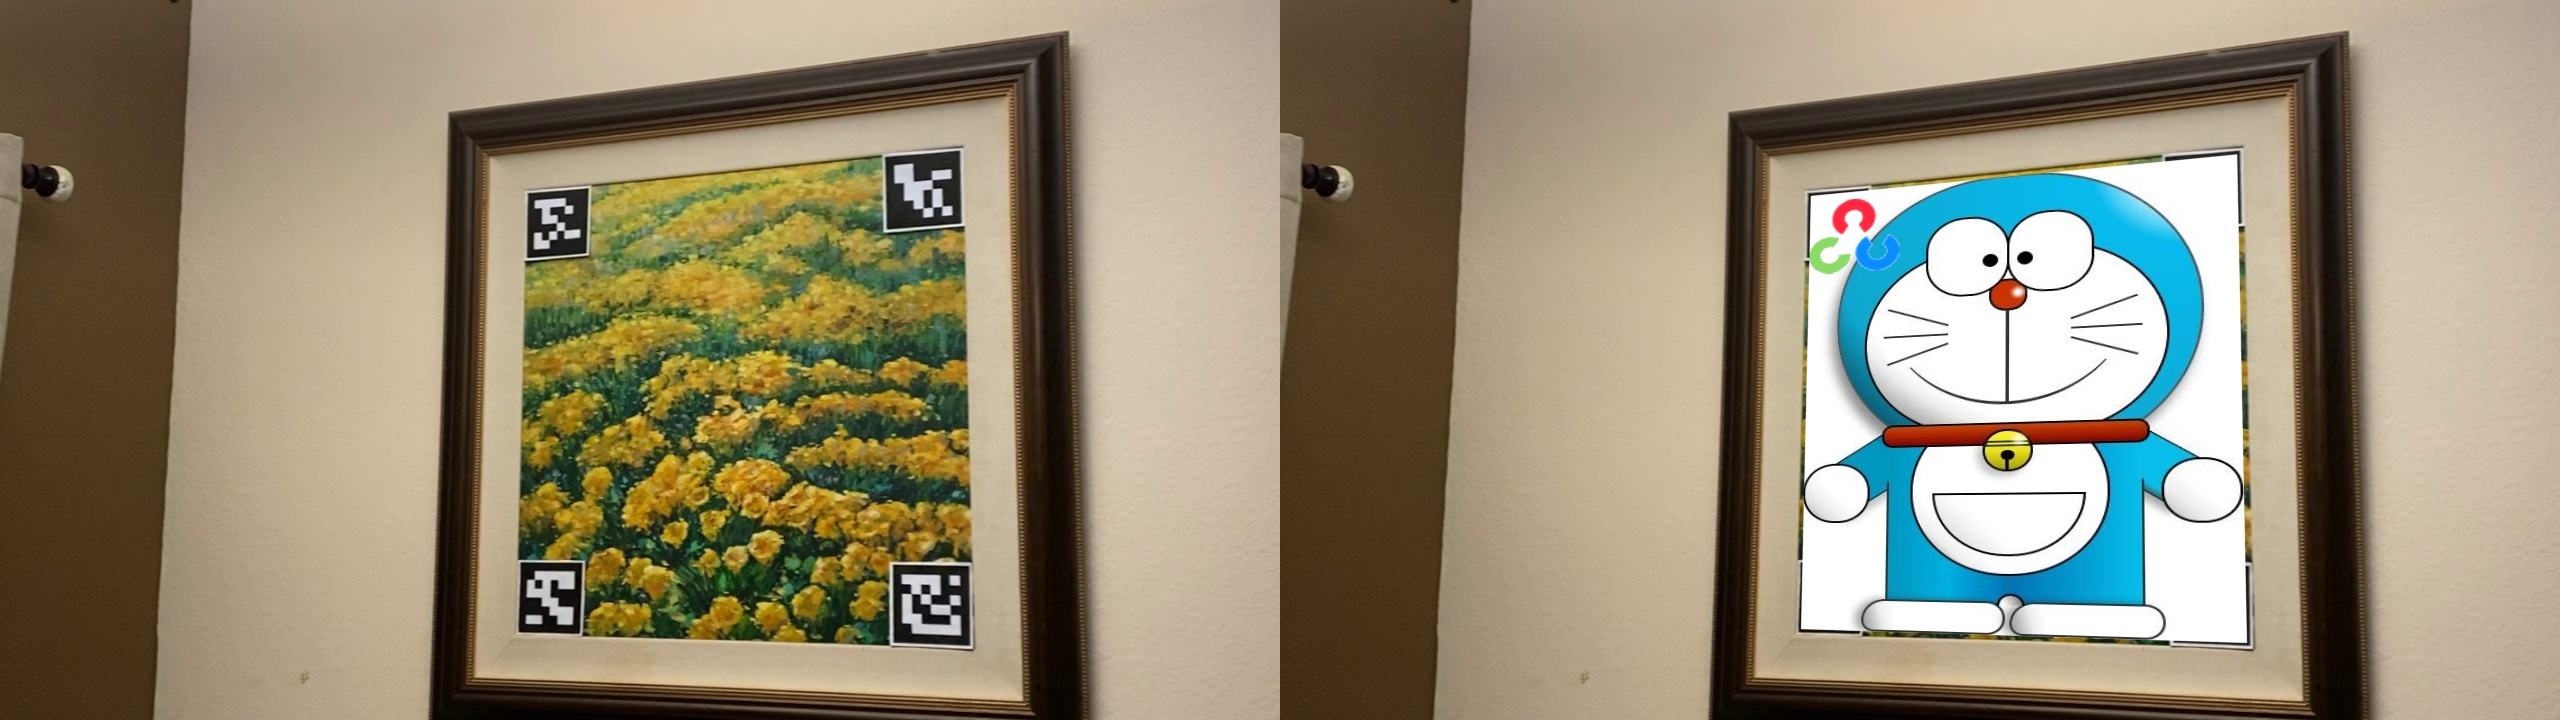